In [1]:
pip install pyupbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 13.2 MB/s 


In [2]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd

import math
import csv
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
#데이터 불러오기
import pyupbit
from pyupbit.quotation_api import get_tickers

ETH_price = pyupbit.get_current_price("KRW-ETH")

df_ETH = pyupbit.get_ohlcv("KRW-ETH","hour",1581, to = '20220501')
#220501까지 1581일
#pyupbit.get_ohlcv로 받으면 open, high, low, close, volume거래량, value가 기본으로 있는건지?

df_ETH = df_ETH.drop("value",axis=1)
#value는 학습에 쓰는 일이 없어서 먼저 제외
print(df_ETH)

                          open       high        low      close         volume
2018-01-01 09:00:00  1028000.0  1076000.0  1011500.0  1057000.0   51315.571156
2018-01-02 09:00:00  1056500.0  1270500.0  1051000.0  1177000.0  158481.289301
2018-01-03 09:00:00  1177000.0  1324500.0  1157500.0  1295500.0   83430.944304
2018-01-04 09:00:00  1295500.0  1518000.0  1269000.0  1439500.0   97018.955981
2018-01-05 09:00:00  1439500.0  1645000.0  1406500.0  1554500.0  109665.854669
...                        ...        ...        ...        ...            ...
2022-04-26 09:00:00  3766000.0  3799000.0  3553000.0  3596000.0   39317.760548
2022-04-27 09:00:00  3597000.0  3702000.0  3580000.0  3677000.0   24282.807473
2022-04-28 09:00:00  3677000.0  3786000.0  3646000.0  3737000.0   26791.875509
2022-04-29 09:00:00  3737000.0  3753000.0  3603000.0  3628000.0   26801.567048
2022-04-30 09:00:00  3630000.0  3656000.0  3564000.0  3570000.0   17625.435214

[1581 rows x 5 columns]


In [5]:
#결측치 확인
df_ETH.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [ ]:
#0724   정규화와 train test 분리는 순서 상관없는지?

In [6]:
#minmax 정규화
from sklearn.preprocessing import MinMaxScaler
#0724  StandardScaler	(각 특징의 평균을 0, 분산을 1이 되도록 변경) 는 필요없는지?

mmsc = MinMaxScaler() #sc를 mmsc로 이름변경했습니다
df_ETH = df_ETH.drop('volume',axis=1)
# volume은 포함하는 경우도 있고 아닌 경우도 있어서 여기에서 일단 제외

# open, high, low, close 4개로
df_ETH = mmsc.fit_transform(df_ETH)

In [7]:
#훈련데이터, 시험데이터 나누기
import pandas as pd
df_ETH = pd.DataFrame(df_ETH)

df_train = df_ETH.iloc[:1200,:5].values
df_test = df_ETH.iloc[:381,:5].values

In [8]:
#학습에 사용할 수 있도록 input 데이터 조정하기
import numpy as np

x_train = []
y_train = []
y_train_stacked = []

for i in range(3,1199):
    x_train.append(df_train[i-3:i,:])
    y_train.append(df_train[i:i+1,3])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(1196,3,4))


x_test = []
y_test = []

for i in range(3,380):
    x_test.append(df_test[i-3:i,:])
    y_test.append(df_test[i:i+1,3])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test,(377,3,4))

In [9]:
import tensorflow as tf 

In [10]:
#LSTM 모델
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import RMSprop, Nadam, Adam
#오류 발생해서 아래 nadam부분 수정
# https://blog.naver.com/losenoid06290/222640813980


lstm_model = Sequential()

lstm_model.add(LSTM(units = 50,
                    return_sequences = True,
                    input_shape = (3,4),
                    activation = 'tanh'))

lstm_model.add(LSTM(units = 50,
                    activation = 'tanh'))

lstm_model.add(Dense(units = 1))

lstm_model.compile(optimizer = Nadam(lr=0.01),
                  loss = 'Huber')

lstm_model.fit(x_train,y_train, epochs = 100, batch_size = 32, verbose = 0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [11]:
#예측값
lstm_prediction = lstm_model.predict(x_test)

lstm_prediction.shape

(377, 1)

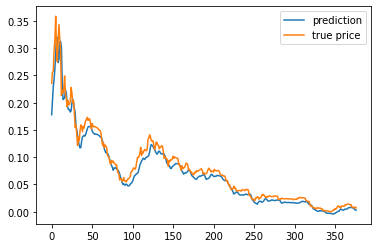

In [12]:
#예측값과 실제값 비교하기
import matplotlib.pyplot as plt

x1 = []
for i in range(377):
    x1.append(i)

    
x2 = []
for i in range(377):
    x2.append(i)  
        
    
plt.plot(x1,lstm_prediction,label = 'prediction')
plt.plot(x2, y_test,label = 'true price')
plt.legend()
plt.show()